In [1]:
import os
import sys
sys.path.append("./src")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.layers import Activation, Dropout, Lambda, Dense
from tensorflow.keras import Sequential
from IntegratedGradients import *
import json
from tensorflow import keras
#from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from tensorflow.keras.applications import resnet_v2
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import dlib
import io
from util import *

In [2]:
def fig2img(fig):
    """Convert a Matplotlib figure to a PIL Image and return it"""
    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    img = Image.open(buf)
    return img

In [3]:
with open("./config/parameters.json") as f:
    data = json.load(f)
f.close()

In [4]:
ig_param = data["integrated_grad"]
model_param_path,_, _, _, target, mapping, _, _ = ig_param.values()

In [5]:
mapping

'./mapping/race.json'

In [10]:
model = keras.models.load_model(model_param_path)
ig = integrated_gradients(model)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Evaluated output channel (0-based index): All
Building gradient functions
Progress: 100.0%
Done.


In [6]:
lookup = None
image_path = "./IMG_3531.jpg"

In [209]:
Image.open(image_path)

PIL.MpoImagePlugin.MpoImageFile

In [20]:

mapping = os.path.join("./mapping", target + ".json")
with open(mapping) as f:
    mapping_dict = json.load(f)
f.close()

mapping_dict = {key.lower():val for key, val in mapping_dict.items()}
mapping_dict_rev = {val:key for key, val in mapping_dict.items()}





In [39]:
def detect_face(image_path, im_size = 224, default_max_size=800,size = 300, padding = 0.25):
    cnn_face_detector = dlib.cnn_face_detection_model_v1('./dlib_mod/mmod_human_face_detector.dat')
    sp = dlib.shape_predictor('./dlib_mod/shape_predictor_5_face_landmarks.dat')
    base = 2000  # largest width and height

    img = dlib.load_rgb_image(image_path)
    old_height, old_width, _ = img.shape
    old_height, old_width, _ = img.shape

    if old_width > old_height:
        new_width, new_height = default_max_size, int(default_max_size * old_height / old_width)
    else:
        new_width, new_height =  int(default_max_size * old_width / old_height), default_max_size
    img = dlib.resize_image(img, rows=new_height, cols=new_width)
    dets = cnn_face_detector(img, 1)
    num_faces = len(dets)
    if num_faces == 0:
        print("Sorry, there were no faces found in '{}'".format(image_path))
        return
    elif num_faces > 1:
        print("Multiple face in '{}'. A random face will be returned".format(image_path))
    faces = dlib.full_object_detections()
    for detection in dets:
        rect = detection.rect
        faces.append(sp(img, rect))
    image = dlib.get_face_chips(img, faces, size=size, padding = padding)[0]

    image = Image.fromarray(image, 'RGB')
    image = image.resize((im_size, im_size))

    #image = np.array(image) / 255.0
    #ori_img = np.array(image)
    #processed_img = resnet_v2.preprocess_input(np.array(image))
    #processed_img = processed_img[None,:]
    return image

In [40]:
processed_image = detect_face(image_path)

In [59]:
type(processed_image)

PIL.Image.Image

In [49]:
a = resnet_v2.preprocess_input(np.array(processed_image)[None,:])

In [51]:
from matplotlib.backends.backend_agg import FigureCanvasAgg
from PIL import Image


def testing(PIL_img, target, lookup = None):
    if target == "race":
        model_path = "./models/race/race_v6.hdf5"
    elif target == "age":
        model_path = "./models/age/age_v1.hdf5"
    else:
        model_path = "./models/gender/gender_v1.hdf5"
        
    model = keras.models.load_model(model_path)
    ig = integrated_gradients(model)

    mapping = os.path.join("./mapping", target + ".json")
    with open(mapping) as f:
        mapping_dict = json.load(f)
    f.close()

    mapping_dict = {key.lower():val for key, val in mapping_dict.items()}
    mapping_dict_rev = {val:key for key, val in mapping_dict.items()}
    
    output_prob = model.predict(PIL_img).squeeze()
    pred_idx = output_prob.argmax()
    
    if lookup == None:
        pass
    else:
        pred_idx = mapping_dict[lookup]

    ex = ig.explain(processed_image.squeeze(), outc=pred_idx)


    # Plot them
    th = max(np.abs(np.min(ex)), np.abs(np.max(ex)))

    plt.figure(figsize = (6, 6))
    plt.imshow(ex[:,:,0], cmap="seismic", vmin=-1*th, vmax=th)
    plt.title("heatmap for {} {} with probability {:.2f}".format(target, mapping_dict_rev[pred_idx],
                                                                 output_prob[pred_idx]), fontsize=12)
    
    fig = plt.gcf()
    im = fig2img(fig)

    return im


Evaluated output channel (0-based index): All
Building gradient functions
Progress: 100.0%
Done.
Explaning the 1th output.


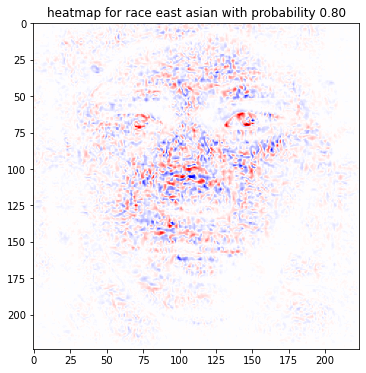

In [52]:
im = testing(a, "race")

In [57]:
type(im)

PIL.PngImagePlugin.PngImageFile

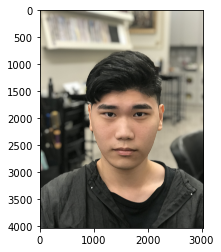

In [191]:
plt.close()
plt.imshow(plt.imread(image_path))

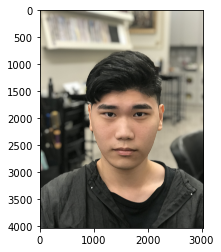

In [194]:
fig = plt.gcf()
plt.imshow(plt.imread(image_path))

In [187]:
fig

<AxesSubplot:>

In [150]:
def fig2img(fig):
    """Convert a Matplotlib figure to a PIL Image and return it"""
    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    img = Image.open(buf)
    return img

In [195]:
a = fig2img(fig)

In [172]:
f = plt.figure(0)

<Figure size 432x288 with 0 Axes>

In [190]:
fig2img(fig)

AttributeError: 'AxesSubplot' object has no attribute 'savefig'

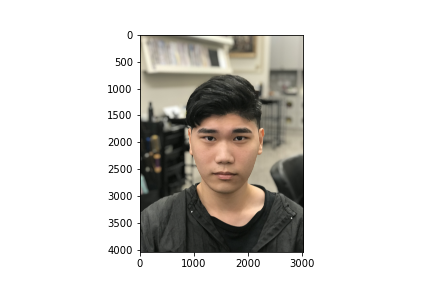

In [196]:
a